In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold

In [ ]:
warnings.filterwarnings("ignore")

In [2]:
data = loadmat('PaviaU.mat')['paviaU']

gt = loadmat('PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))  #düzleştirip dataframe oluşturuyoruz

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

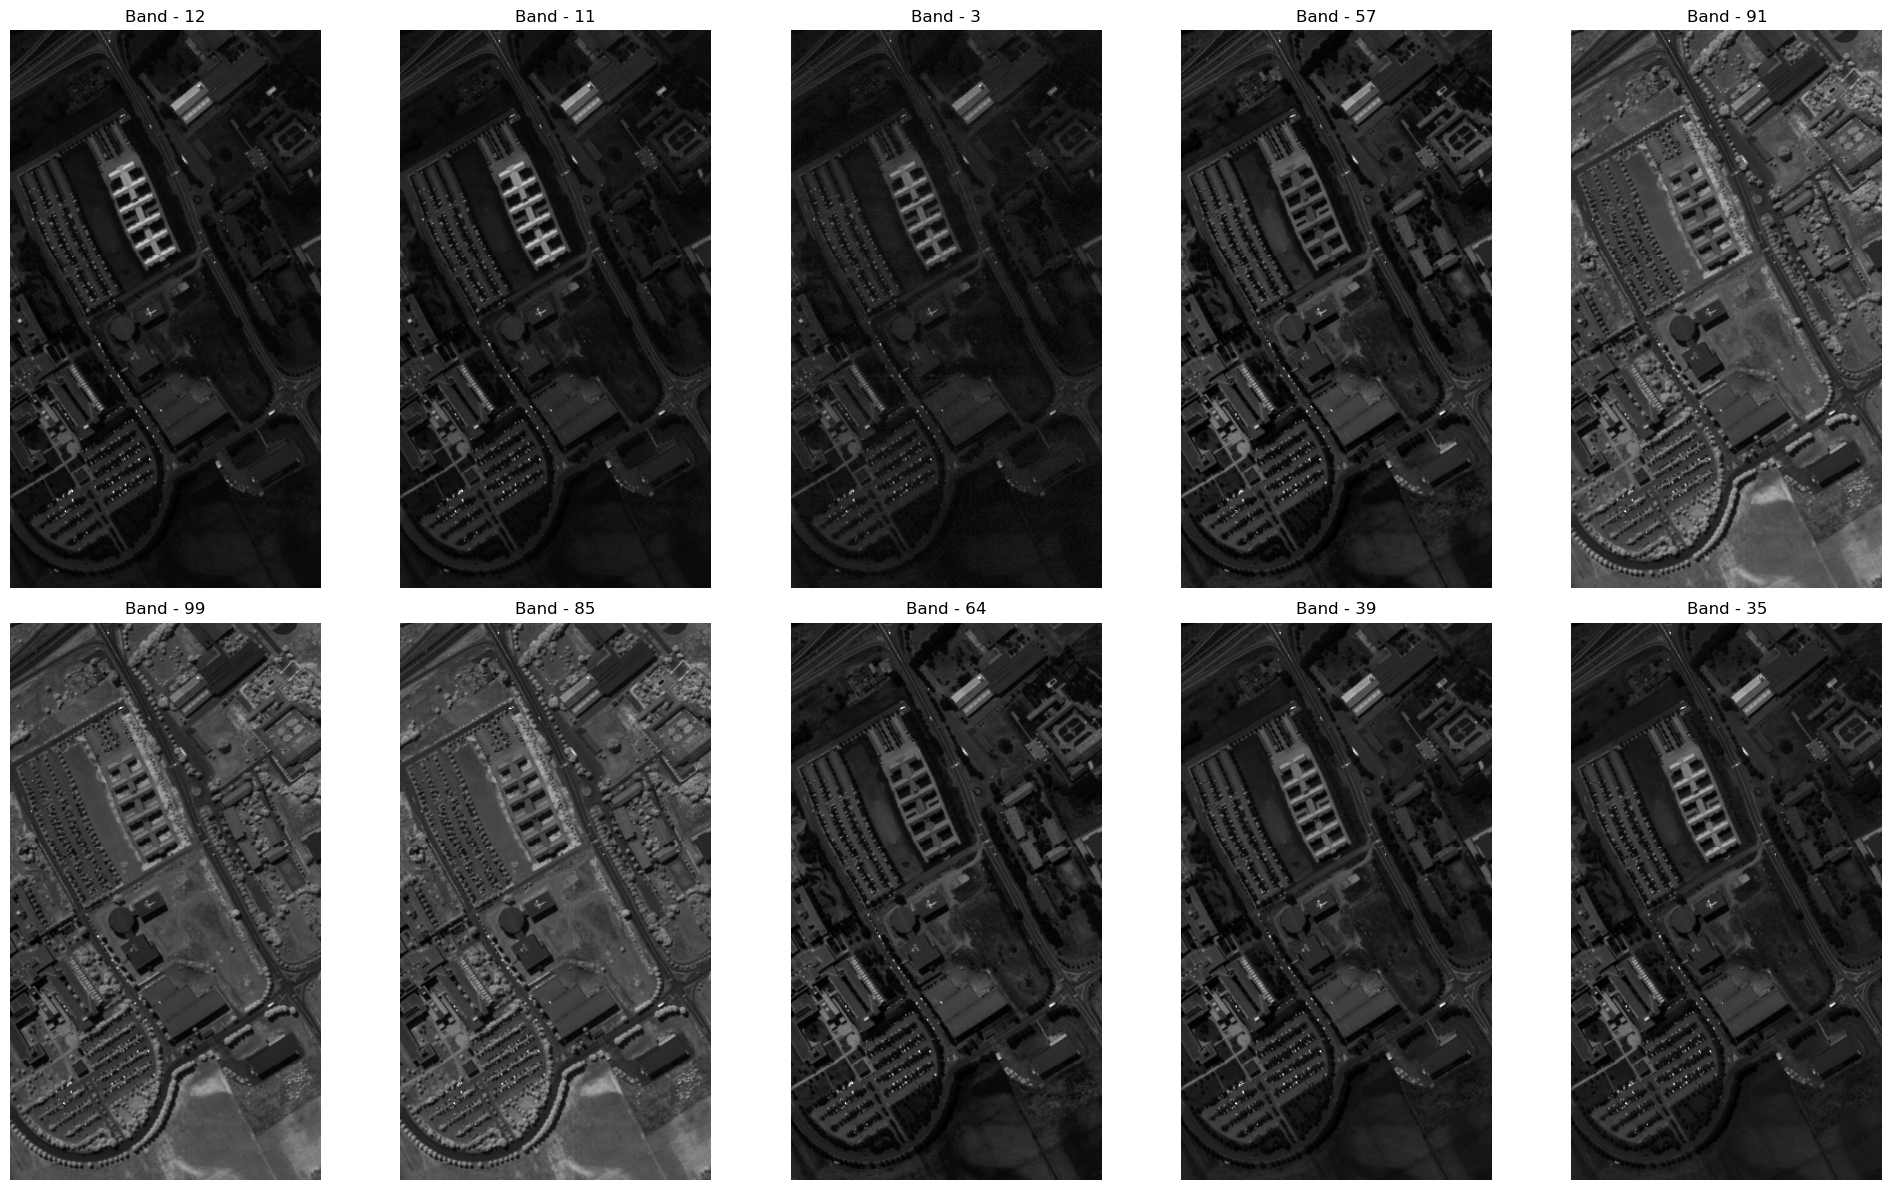

In [3]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()

plt.show()

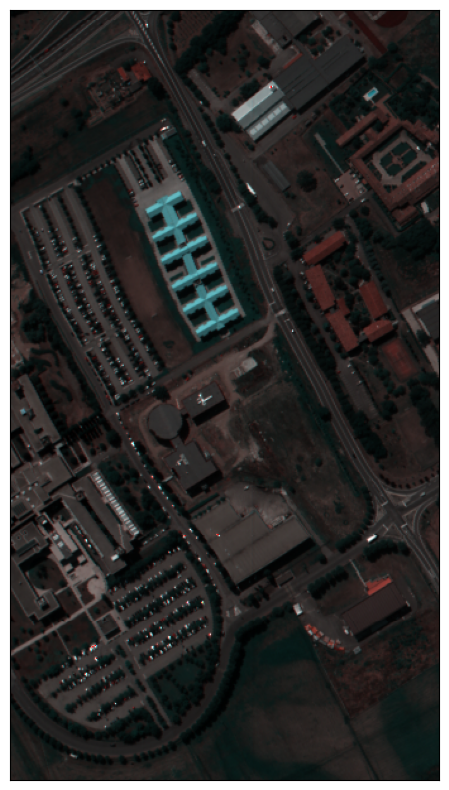

In [4]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize=(12, 10)) 

plt.show()

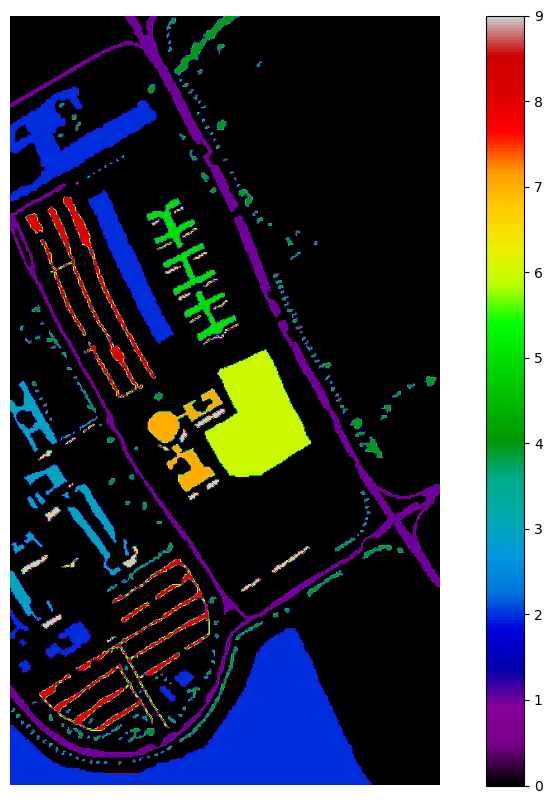

In [5]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

In [6]:
X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values

In [8]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LFDA
from sklearn.impute import SimpleImputer

veri = []
# LFDA modeli için parametreler
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lfda = LFDA(k=2)
knn = KNeighborsClassifier(n_neighbors=7)

fold_index = 1
for test_index, train_index in kf.split(X):
    print(f"Fold {fold_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    # Veri setini train ve test olarak bölmek
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Eksik değerleri kontrol etmek ve ortalama ile doldurmak
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Modeli eğitme
    lfda.fit(X_train, y_train)
    knn.fit(lfda.transform(X_train), y_train)


    lfda_acc = knn.score(lfda.transform(X_test), y_test)
    print('lfda accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], lfda_acc))
    
    veri.append(lfda_acc)    

    fold_index += 1
    
# Dizinin ortalamasını bulalım
ortalama = np.mean(veri)

# Dizinin standart sapmasını bulalım
standart_sapma = np.std(veri)

print("Veri kümesinin ortalaması:", ortalama)
print("Veri kümesinin standart sapması:", standart_sapma)

Fold 1 -> Train: 8556, Test: 34220
lfda accuracy on test set of 34220 points: 0.8884
Fold 2 -> Train: 8555, Test: 34221
lfda accuracy on test set of 34221 points: 0.9005
Fold 3 -> Train: 8555, Test: 34221
lfda accuracy on test set of 34221 points: 0.8964
Fold 4 -> Train: 8555, Test: 34221
lfda accuracy on test set of 34221 points: 0.8958
Fold 5 -> Train: 8555, Test: 34221
lfda accuracy on test set of 34221 points: 0.8928
Veri kümesinin ortalaması: 0.8947890969160456
Veri kümesinin standart sapması: 0.004004088566264935


In [9]:
y_pred = knn.predict(lfda.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8928435755822448
Confusion Matrix:
[[ 4765    25    87     0     0    35   269   141     0]
 [    2 14868     2    19     0    97     0     7     0]
 [   43     7  1195     0     0     9     4   438     0]
 [    3   306     0  2074     0     7     0     0     0]
 [    3     0     0     0  1078     0     0     0     0]
 [   27  1367    22     2     0  2493     5    71     0]
 [  135     0     4     0     0     5   919     1     0]
 [   93    34   363     0     0    19     9  2417     0]
 [    6     0     0     0     0     0     0     0   745]]
Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.90      0.92      5322
           2       0.90      0.99      0.94     14995
           3       0.71      0.70      0.71      1696
           4       0.99      0.87      0.92      2390
           5       1.00      1.00      1.00      1081
           6       0.94      0.63      0.75      3987
           7       0.76      0.86    

In [10]:
from sklearn.metrics import accuracy_score

# Genel doğruluk hesaplama
genel_dogruluk = accuracy_score(y_test, y_pred)
print("Genel Doğruluk:", genel_dogruluk)

Genel Doğruluk: 0.8928435755822448


In [11]:
from sklearn.metrics import f1_score

# F-Measure hesaplama
f_measure = f1_score(y_test, y_pred, average='macro')
print("F-Measure:", f_measure)

F-Measure: 0.8722026530173598


In [12]:
from sklearn.metrics import cohen_kappa_score

# Kappa değeri hesaplama
kappa_degeri = cohen_kappa_score(y_test, y_pred)
print("Kappa Değeri:", kappa_degeri)

Kappa Değeri: 0.8548481887741763
